# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en matlab


In [2]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total.mat')
conjunto_datos= datos_matlab.get('photodefbox2_todo')
conjunto_datos.shape

(50000, 3517)

In [3]:
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
# hay dos L1 con 640 sensores (40*16)
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=10
val_size=80
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]


x_train = X_train
x_test = X_test

datos_trA=np.zeros((X_train.shape[0]*L1A,input_output_dim_A))
for i in range(x_train.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_train[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    datos_trA[(i)*L1A :(i+1)*L1A,:] = ideaA  
 
x_trainA = datos_trA;

datos_testA=np.zeros((X_test.shape[0]*L1A,input_output_dim_A))
for i in range(x_test.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_test[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    datos_testA[(i)*L1A :(i+1)*L1A,:] = ideaA  
 
x_testA = datos_testA;





print(x_trainA.shape)
print(x_testA.shape)


datos_trB=np.zeros((X_train.shape[0]*L1B,input_output_dim_B))
for i in range(x_train.shape[0]):
    for k in range(L1B):
        ideaB[k,:]=x_train[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+(k+1)*input_output_dim_B]
    datos_trB[(i)*L1B :(i+1)*L1B,:] = ideaB  
 
x_trainB = datos_trB;

datos_testB=np.zeros((X_test.shape[0]*L1B,input_output_dim_B))
for i in range(x_test.shape[0]):
    for k in range(L1B):
        ideaB[k,:]=x_test[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+(k+1)*input_output_dim_B]
    datos_testB[(i)*L1B :(i+1)*L1B,:] = ideaB  
 
x_testB = datos_testB;





print(x_trainB.shape)
print(x_testB.shape)


50000
conjunto_datos shape: (50000, 3517)
5000
40000
5000
(25000, 600)
(25000, 600)
(5000, 500)
(5000, 500)


## Network parameters:

In [4]:
use_regularizer = True
my_regularizer = None
my_epochs = 50
hidden_size=320
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

   
    
encoding_dimA = hidden_size  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_imgA = Input(shape=(img_rows*img_colsA,))

# "encoded" is the encoded representation of the input
encodedA = Dense(encoding_dimA, activation='sigmoid', use_bias=False,bias_initializer='random_uniform')(input_imgA)
# "decoded" is the lossy reconstruction of the input
decodedA = Dense(img_colsA*img_rows, activation='linear',use_bias=True,bias_initializer='random_uniform')(encodedA)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoderA = Model(input_imgA, decodedA)

encoding_dimB = hidden_size  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_imgB = Input(shape=(img_rows*img_colsB,))

# "encoded" is the encoded representation of the input
encodedB = Dense(encoding_dimB, activation='sigmoid', use_bias=False,bias_initializer='random_uniform')(input_imgB)
# "decoded" is the lossy reconstruction of the input
decodedB = Dense(img_colsB*img_rows, activation='linear',use_bias=True,bias_initializer='random_uniform')(encodedB)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoderB = Model(input_imgB, decodedB)

## Prepare data into training and test set.

In [5]:
x_trainA = x_trainA.reshape(x_trainA.shape[0], img_colsA, img_rows,1)
# X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
x_testA = x_testA.reshape(x_testA.shape[0], img_colsA, img_rows,1)


input_shapeA = (img_colsA, img_rows,1)
#input_shape=input_shape.astype('int32')

In [6]:
x_trainA = x_trainA.astype('float32')
# X_val= X_val.astype('float32')
x_testA = x_testA.astype('float32')

print('X_train shape:', x_trainA.shape)
# print(X_train.shape[0], 'train samples')
# print(X_val.shape[0], 'validation samples')

X_train=x_trainA
X_test=x_testA

X_train shape: (25000, 30, 20, 1)


Display 20 random training images using image

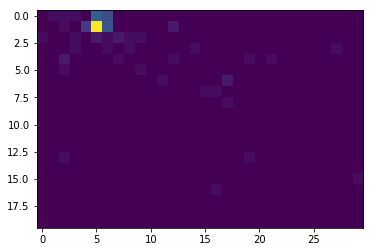

12579


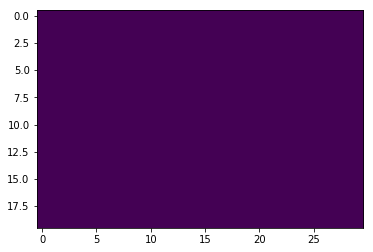

9531


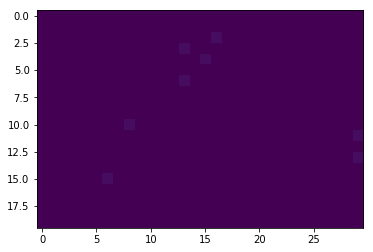

6011


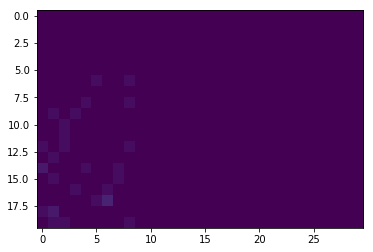

12027


In [7]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [img_rows, img_colsA]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [8]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)


(25000, 600)
(25000, 600)


In [9]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=1
factor_aprendizaje=0.0001
print(min_max_scaler)
#x_train_scaled = min_max_scaler.transform(x_train)
#x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(x_train/supermax)
x_test_scaled=(x_test/supermax)
#min_max_scaler.scale_
# print(x_train[20413])
# print(x_train_scaled[20413])
# print(x_test[20413])
# print(x_test_scaled[20413])

MinMaxScaler(copy=True, feature_range=(0, 1))


## Build the autoencoder. 

Create our metrics, for example energy

In [10]:
import keras.backend as KK
import keras.callbacks as KKcall

In [11]:
class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.sum((y_val+1)*supermax/2, axis=1)
        y_predict = np.sum((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.mean(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()

def energy_error(y_true, y_pred):
    veamos_energia=(KK.sum(y_pred, axis=1)-KK.sum(y_true,axis=1))
    return KK.mean(veamos_energia,axis=-1)

In [12]:
# this model maps an input to its encoded representation
encoderA = Model(input_imgA, encodedA)

# create a placeholder for an encoded (32-dimensional) input
encoded_inputA = Input(shape=(encoding_dimA,))
# retrieve the last layer of the autoencoder model
decoder_layerA = autoencoderA.layers[-1]
# create the decoder model
decoderA = Model(encoded_inputA, decoder_layerA(encoded_inputA))

autoencoderA.compile(optimizer='RMSprop', loss='mse', metrics=[energy_error])

autoencoderA.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [13]:
algoritmo='RMSprop'
experimento="scaledA_{}_encoder_without_bias_sig_sig_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/defs/{}{}{}{}".format(encoding_dimA,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
results=autoencoderA.fit(x_train_scaled, x_train_scaled,
                epochs=100,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop, metrics],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 3s 122us/step - loss: 17.5369 - energy_error: -56.5350 - val_loss: 19.8187 - val_energy_error: -28.3051
Epoch 2/100
25000/25000 [==============================] - 1s 27us/step - loss: 17.2018 - energy_error: -25.8860 - val_loss: 19.5291 - val_energy_error: -29.1767
Epoch 3/100
25000/25000 [==============================] - 1s 24us/step - loss: 16.9332 - energy_error: -29.7020 - val_loss: 19.2763 - val_energy_error: -33.2321
Epoch 4/100
25000/25000 [==============================] - 1s 25us/step - loss: 16.7015 - energy_error: -32.7285 - val_loss: 19.0603 - val_energy_error: -35.0305
Epoch 5/100
25000/25000 [==============================] - 1s 26us/step - loss: 16.5027 - energy_error: -33.6434 - val_loss: 18.8760 - val_energy_error: -35.2434
Epoch 6/100
25000/25000 [==============================] - 1s 26us/step - loss: 16.3306 - energy_error: -33.3979 - val_loss: 18.7172 - val_

25000/25000 [==============================] - 1s 27us/step - loss: 13.9106 - energy_error: -19.4836 - val_loss: 16.6014 - val_energy_error: -27.5449
Epoch 52/100
25000/25000 [==============================] - 1s 26us/step - loss: 13.8848 - energy_error: -19.3946 - val_loss: 16.5803 - val_energy_error: -27.5069
Epoch 53/100
25000/25000 [==============================] - 1s 26us/step - loss: 13.8594 - energy_error: -19.3078 - val_loss: 16.5595 - val_energy_error: -27.4713
Epoch 54/100
25000/25000 [==============================] - 1s 26us/step - loss: 13.8344 - energy_error: -19.2233 - val_loss: 16.5392 - val_energy_error: -27.4412
Epoch 55/100
25000/25000 [==============================] - 1s 26us/step - loss: 13.8098 - energy_error: -19.1413 - val_loss: 16.5192 - val_energy_error: -27.4140
Epoch 56/100
25000/25000 [==============================] - 1s 25us/step - loss: 13.7856 - energy_error: -19.0612 - val_loss: 16.4996 - val_energy_error: -27.3872
Epoch 57/100
25000/25000 [=========

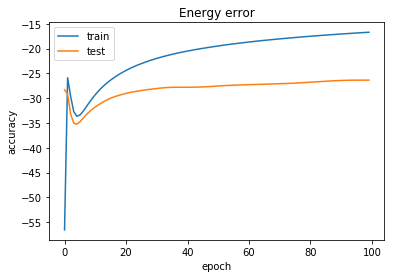

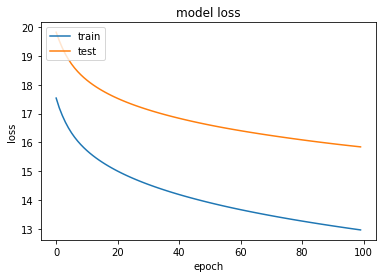

In [14]:
# summarize history for categorical accuracy
plt.plot(results.history['energy_error'])
plt.plot(results.history['val_energy_error'])
plt.title('Energy error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# import pandas as pd 
# autoencoder.evaluate(x=x_test_scaled,y=x_test_scaled)
# D=metrics.get_data()


# energies=pd.DataFrame(D).values.reshape(len(D))
# valores=len(energies)
# plt.plot(range(valores),energies) 

# plt.show()

In [16]:
autoencoderA.save_weights('../redes_compresoras/defs/compresor_python_{}{}{}{}'.format(encoding_dimA,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)
#autoencoder.load_weights('../redes_compresoras/defs/compresor_python_320RMSpropscaled_100_encoder_without_bias_sig_sig_lr_0.00012018-11-03 09:43:55.047213')

In [17]:
# standard_scores = encoder.predict(x_test_scaled).ravel()
# #regularized_scores = encoded_regularized.predict(x_test).ravel()
# sns.distplot(standard_scores, hist=True, label='standard model')
# #sns.distplot(regularized_scores, hist=False, label='regularized model')

In [18]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
#decoded_imgs_scaled = autoencoder.predict(x_test_min_max)
decoded_imgs_scaled = autoencoderA.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaled)
#decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


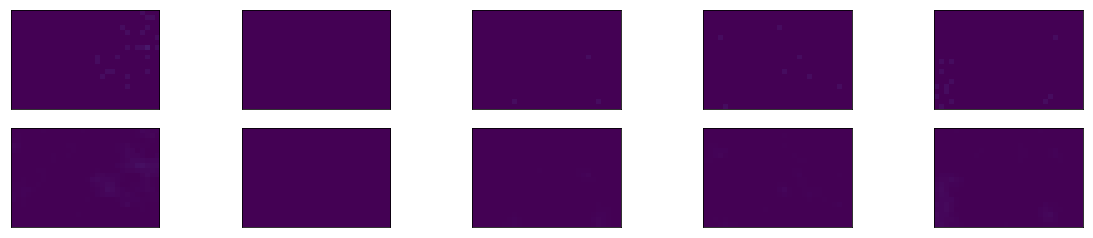

5265


In [19]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(img_colsA,img_rows ).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(img_colsA, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)
# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


In [20]:
x_trainB = x_trainB.reshape(x_trainB.shape[0], img_colsB, img_rows,1)
# X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
x_testB = x_testB.reshape(x_testB.shape[0], img_colsB, img_rows,1)


input_shapeB = (img_colsB, img_rows,1)
#input_shape=input_shape.astype('int32')

In [21]:
x_trainB = x_trainB.astype('float32')
# X_val= X_val.astype('float32')
x_testB = x_testB.astype('float32')

print('X_train shape:', x_trainB.shape)
# print(X_train.shape[0], 'train samples')
# print(X_val.shape[0], 'validation samples')

X_train=x_trainB
X_test=x_testB

X_train shape: (5000, 25, 20, 1)


Display 20 random training images using image

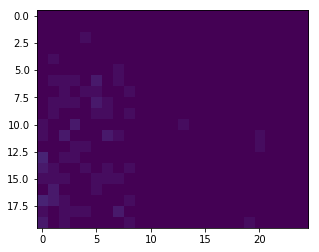

1479


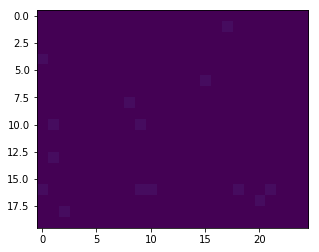

2498


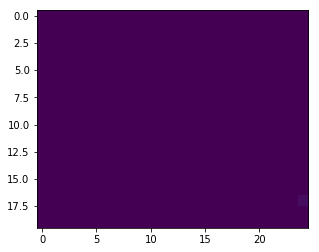

897


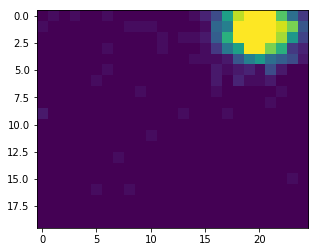

3697


In [22]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [img_rows, img_colsB]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [23]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)


(5000, 500)
(5000, 500)


In [24]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=1
factor_aprendizaje=0.0001
print(min_max_scaler)
# x_train_scaled = min_max_scaler.transform(x_train)
# x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(x_train/supermax)
x_test_scaled=(x_test/supermax)
#min_max_scaler.scale_
# print(x_train[2413])
# print(x_train_scaled[2413])
# print(x_test[2413])
# print(x_test_scaled[2413])

MinMaxScaler(copy=True, feature_range=(0, 1))


## Build the autoencoder. 

Create our metrics, for example energy

In [25]:
import keras.backend as KK
import keras.callbacks as KKcall

In [26]:
class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.sum((y_val+1)*supermax/2, axis=1)
        y_predict = np.sum((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.mean(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()

def energy_error(y_true, y_pred):
    veamos_energia=(KK.sum(y_pred, axis=1)-KK.sum(y_true,axis=1))
    return KK.mean(veamos_energia,axis=-1)

In [27]:
# this model maps an input to its encoded representation
encoderB = Model(input_imgB, encodedB)

# create a placeholder for an encoded (32-dimensional) input
encoded_inputB = Input(shape=(encoding_dimB,))
# retrieve the last layer of the autoencoder model
decoder_layerB = autoencoderB.layers[-1]
# create the decoder model
decoder = Model(encoded_inputB, decoder_layerB(encoded_inputB))

autoencoderB.compile(optimizer='RMSprop', loss='mse', metrics=[energy_error])

autoencoderB.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [28]:
algoritmo='RMSprop'
experimento="scaledB_{}_encoder_without_bias_sig_sig_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/defs/{}{}{}{}".format(encoding_dimB,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
results=autoencoderB.fit(x_train_scaled, x_train_scaled,
                epochs=500,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop, metrics],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 5000 samples, validate on 5000 samples
Epoch 1/500
5000/5000 [==============================] - 0s 63us/step - loss: 20.0689 - energy_error: -97.2088 - val_loss: 21.9992 - val_energy_error: -67.8794
Epoch 2/500
5000/5000 [==============================] - 0s 31us/step - loss: 19.9080 - energy_error: -56.1619 - val_loss: 21.8967 - val_energy_error: -41.2522
Epoch 3/500
5000/5000 [==============================] - 0s 24us/step - loss: 19.8166 - energy_error: -36.8680 - val_loss: 21.8231 - val_energy_error: -28.6113
Epoch 4/500
5000/5000 [==============================] - 0s 23us/step - loss: 19.7415 - energy_error: -28.2202 - val_loss: 21.7581 - val_energy_error: -23.1992
Epoch 5/500
5000/5000 [==============================] - 0s 29us/step - loss: 19.6718 - energy_error: -24.4064 - val_loss: 21.6962 - val_energy_error: -20.6666
Epoch 6/500
5000/5000 [==============================] - 0s 24us/step - loss: 19.6048 - energy_error: -22.6165 - val_loss: 21.6362 - val_energy_error: -

5000/5000 [==============================] - 0s 23us/step - loss: 17.7580 - energy_error: -27.3489 - val_loss: 20.1034 - val_energy_error: -31.4739
Epoch 52/500
5000/5000 [==============================] - 0s 31us/step - loss: 17.7321 - energy_error: -27.2439 - val_loss: 20.0851 - val_energy_error: -31.5961
Epoch 53/500
5000/5000 [==============================] - 0s 26us/step - loss: 17.7065 - energy_error: -27.1394 - val_loss: 20.0671 - val_energy_error: -31.7142
Epoch 54/500
5000/5000 [==============================] - 0s 27us/step - loss: 17.6812 - energy_error: -27.0354 - val_loss: 20.0495 - val_energy_error: -31.8280
Epoch 55/500
5000/5000 [==============================] - 0s 28us/step - loss: 17.6562 - energy_error: -26.9325 - val_loss: 20.0321 - val_energy_error: -31.9381
Epoch 56/500
5000/5000 [==============================] - 0s 33us/step - loss: 17.6316 - energy_error: -26.8310 - val_loss: 20.0150 - val_energy_error: -32.0449
Epoch 57/500
5000/5000 [=======================

Epoch 102/500
5000/5000 [==============================] - 0s 31us/step - loss: 16.7408 - energy_error: -23.0826 - val_loss: 19.4365 - val_energy_error: -35.3290
Epoch 103/500
5000/5000 [==============================] - 0s 26us/step - loss: 16.7251 - energy_error: -23.0203 - val_loss: 19.4268 - val_energy_error: -35.3872
Epoch 104/500
5000/5000 [==============================] - 0s 26us/step - loss: 16.7095 - energy_error: -22.9585 - val_loss: 19.4172 - val_energy_error: -35.4439
Epoch 105/500
5000/5000 [==============================] - 0s 29us/step - loss: 16.6940 - energy_error: -22.8973 - val_loss: 19.4077 - val_energy_error: -35.4996
Epoch 106/500
5000/5000 [==============================] - 0s 26us/step - loss: 16.6786 - energy_error: -22.8368 - val_loss: 19.3982 - val_energy_error: -35.5547
Epoch 107/500
5000/5000 [==============================] - 0s 27us/step - loss: 16.6634 - energy_error: -22.7769 - val_loss: 19.3888 - val_energy_error: -35.6093
Epoch 108/500
5000/5000 [===

5000/5000 [==============================] - 0s 31us/step - loss: 16.0618 - energy_error: -20.5765 - val_loss: 19.0341 - val_energy_error: -36.4761
Epoch 153/500
5000/5000 [==============================] - 0s 28us/step - loss: 16.0500 - energy_error: -20.5359 - val_loss: 19.0274 - val_energy_error: -36.4803
Epoch 154/500
5000/5000 [==============================] - 0s 28us/step - loss: 16.0383 - energy_error: -20.4953 - val_loss: 19.0208 - val_energy_error: -36.4835
Epoch 155/500
5000/5000 [==============================] - 0s 28us/step - loss: 16.0267 - energy_error: -20.4548 - val_loss: 19.0142 - val_energy_error: -36.4859
Epoch 156/500
5000/5000 [==============================] - 0s 26us/step - loss: 16.0151 - energy_error: -20.4146 - val_loss: 19.0077 - val_energy_error: -36.4877
Epoch 157/500
5000/5000 [==============================] - 0s 26us/step - loss: 16.0035 - energy_error: -20.3746 - val_loss: 19.0012 - val_energy_error: -36.4888
Epoch 158/500
5000/5000 [=================

5000/5000 [==============================] - 0s 26us/step - loss: 15.5314 - energy_error: -18.8373 - val_loss: 18.7391 - val_energy_error: -36.5481
Epoch 203/500
5000/5000 [==============================] - 0s 29us/step - loss: 15.5218 - energy_error: -18.8083 - val_loss: 18.7339 - val_energy_error: -36.5542
Epoch 204/500
5000/5000 [==============================] - 0s 29us/step - loss: 15.5123 - energy_error: -18.7795 - val_loss: 18.7288 - val_energy_error: -36.5612
Epoch 205/500
5000/5000 [==============================] - 0s 26us/step - loss: 15.5027 - energy_error: -18.7511 - val_loss: 18.7236 - val_energy_error: -36.5690
Epoch 206/500
5000/5000 [==============================] - 0s 32us/step - loss: 15.4933 - energy_error: -18.7229 - val_loss: 18.7186 - val_energy_error: -36.5775
Epoch 207/500
5000/5000 [==============================] - 0s 26us/step - loss: 15.4838 - energy_error: -18.6948 - val_loss: 18.7135 - val_energy_error: -36.5866
Epoch 208/500
5000/5000 [=================

5000/5000 [==============================] - 0s 28us/step - loss: 15.0875 - energy_error: -17.5790 - val_loss: 18.5074 - val_energy_error: -36.9236
Epoch 253/500
5000/5000 [==============================] - 0s 30us/step - loss: 15.0793 - energy_error: -17.5564 - val_loss: 18.5031 - val_energy_error: -36.9223
Epoch 254/500
5000/5000 [==============================] - 0s 23us/step - loss: 15.0711 - energy_error: -17.5337 - val_loss: 18.4989 - val_energy_error: -36.9202
Epoch 255/500
5000/5000 [==============================] - 0s 25us/step - loss: 15.0630 - energy_error: -17.5112 - val_loss: 18.4946 - val_energy_error: -36.9176
Epoch 256/500
5000/5000 [==============================] - 0s 30us/step - loss: 15.0548 - energy_error: -17.4885 - val_loss: 18.4904 - val_energy_error: -36.9149
Epoch 257/500
5000/5000 [==============================] - 0s 27us/step - loss: 15.0467 - energy_error: -17.4660 - val_loss: 18.4862 - val_energy_error: -36.9123
Epoch 258/500
5000/5000 [=================

5000/5000 [==============================] - 0s 27us/step - loss: 14.7024 - energy_error: -16.5838 - val_loss: 18.3106 - val_energy_error: -36.5329
Epoch 303/500
5000/5000 [==============================] - 0s 30us/step - loss: 14.6952 - energy_error: -16.5671 - val_loss: 18.3069 - val_energy_error: -36.5215
Epoch 304/500
5000/5000 [==============================] - 0s 27us/step - loss: 14.6880 - energy_error: -16.5496 - val_loss: 18.3032 - val_energy_error: -36.5103
Epoch 305/500
5000/5000 [==============================] - 0s 28us/step - loss: 14.6808 - energy_error: -16.5317 - val_loss: 18.2996 - val_energy_error: -36.5026
Epoch 306/500
5000/5000 [==============================] - 0s 27us/step - loss: 14.6736 - energy_error: -16.5152 - val_loss: 18.2960 - val_energy_error: -36.4928
Epoch 307/500
5000/5000 [==============================] - 0s 26us/step - loss: 14.6664 - energy_error: -16.4966 - val_loss: 18.2924 - val_energy_error: -36.4887
Epoch 308/500
5000/5000 [=================

5000/5000 [==============================] - 0s 27us/step - loss: 14.3587 - energy_error: -15.8047 - val_loss: 18.1424 - val_energy_error: -36.1817
Epoch 353/500
5000/5000 [==============================] - 0s 32us/step - loss: 14.3521 - energy_error: -15.7910 - val_loss: 18.1392 - val_energy_error: -36.1759
Epoch 354/500
5000/5000 [==============================] - 0s 26us/step - loss: 14.3456 - energy_error: -15.7761 - val_loss: 18.1361 - val_energy_error: -36.1700
Epoch 355/500
5000/5000 [==============================] - 0s 26us/step - loss: 14.3391 - energy_error: -15.7624 - val_loss: 18.1329 - val_energy_error: -36.1637
Epoch 356/500
5000/5000 [==============================] - 0s 24us/step - loss: 14.3325 - energy_error: -15.7478 - val_loss: 18.1297 - val_energy_error: -36.1571
Epoch 357/500
5000/5000 [==============================] - 0s 27us/step - loss: 14.3260 - energy_error: -15.7344 - val_loss: 18.1266 - val_energy_error: -36.1492
Epoch 358/500
5000/5000 [=================

5000/5000 [==============================] - 0s 23us/step - loss: 14.0463 - energy_error: -15.1370 - val_loss: 17.9952 - val_energy_error: -35.8481
Epoch 403/500
5000/5000 [==============================] - 0s 25us/step - loss: 14.0404 - energy_error: -15.1252 - val_loss: 17.9925 - val_energy_error: -35.8430
Epoch 404/500
5000/5000 [==============================] - 0s 30us/step - loss: 14.0344 - energy_error: -15.1125 - val_loss: 17.9897 - val_energy_error: -35.8384
Epoch 405/500
5000/5000 [==============================] - 0s 28us/step - loss: 14.0285 - energy_error: -15.1007 - val_loss: 17.9869 - val_energy_error: -35.8351
Epoch 406/500
5000/5000 [==============================] - 0s 25us/step - loss: 14.0225 - energy_error: -15.0884 - val_loss: 17.9841 - val_energy_error: -35.8319
Epoch 407/500
5000/5000 [==============================] - 0s 30us/step - loss: 14.0166 - energy_error: -15.0767 - val_loss: 17.9813 - val_energy_error: -35.8295
Epoch 408/500
5000/5000 [=================

5000/5000 [==============================] - 0s 34us/step - loss: 13.7599 - energy_error: -14.5644 - val_loss: 17.8634 - val_energy_error: -35.6434
Epoch 453/500
5000/5000 [==============================] - 0s 26us/step - loss: 13.7544 - energy_error: -14.5526 - val_loss: 17.8610 - val_energy_error: -35.6486
Epoch 454/500
5000/5000 [==============================] - 0s 25us/step - loss: 13.7489 - energy_error: -14.5419 - val_loss: 17.8586 - val_energy_error: -35.6509
Epoch 455/500
5000/5000 [==============================] - 0s 26us/step - loss: 13.7434 - energy_error: -14.5305 - val_loss: 17.8562 - val_energy_error: -35.6535
Epoch 456/500
5000/5000 [==============================] - 0s 30us/step - loss: 13.7379 - energy_error: -14.5196 - val_loss: 17.8538 - val_energy_error: -35.6555
Epoch 457/500
5000/5000 [==============================] - 0s 28us/step - loss: 13.7325 - energy_error: -14.5083 - val_loss: 17.8514 - val_energy_error: -35.6583
Epoch 458/500
5000/5000 [=================

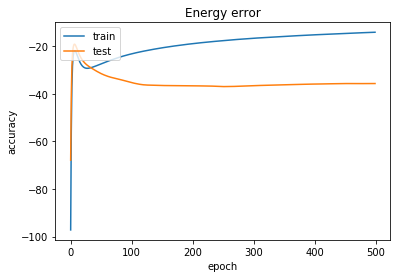

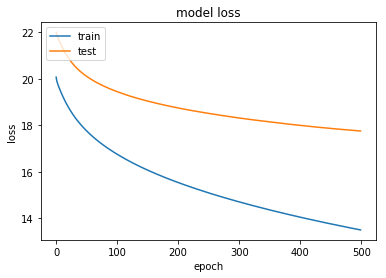

In [29]:
# summarize history for categorical accuracy
plt.plot(results.history['energy_error'])
plt.plot(results.history['val_energy_error'])
plt.title('Energy error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
# import pandas as pd 
# autoencoderB.evaluate(x=x_test_scaled,y=x_test_scaled)
# D=metrics.get_data()


# energies=pd.DataFrame(D).values.reshape(len(D))
# valores=len(energies)
# plt.plot(range(valores),energies) 

# plt.show()

In [31]:
autoencoderB.save_weights('../redes_compresoras/defs/compresor_python_{}{}{}{}'.format(encoding_dimB,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)
#autoencoder.load_weights('../redes_compresoras/defs/compresor_python_320RMSpropscaled_100_encoder_without_bias_sig_sig_lr_0.00012018-11-03 09:43:55.047213')

In [32]:
# standard_scores = encoder.predict(x_test_scaled).ravel()
# #regularized_scores = encoded_regularized.predict(x_test).ravel()
# sns.distplot(standard_scores, hist=True, label='standard model')
# #sns.distplot(regularized_scores, hist=False, label='regularized model')

In [33]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
# decoded_imgs_scaled = autoencoderB.predict(x_test_min_max)
decoded_imgs_scaledB = autoencoderB.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaledB)
# decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


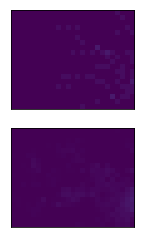

In [34]:
n = 1  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(img_colsB,img_rows ).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(img_colsB, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
# print(idea)
# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


# Vamos a procesar y comprimir con la red

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces

In [35]:
x_total=conjunto_datos[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)

Veamos ahora ciertos estudios

In [36]:
photodefbox2_todo_fil1= datos_matlab.get('photodefbox2_todo_fil1')
numero_muestras=photodefbox2_todo_fil1.shape[0]
x_total=photodefbox2_todo_fil1[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse.shape[0]
mse_idea=np.reshape(mse,(mse.shape[0],1))
photodefbox2_todo_fil1_e=np.concatenate((photodefbox2_todo_fil1,mse_idea),axis=1)

In [37]:
photodefbox2_todo_fil2= datos_matlab.get('photodefbox2_todo_fil2')
numero_muestras=photodefbox2_todo_fil2.shape[0]
x_total=photodefbox2_todo_fil2[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse.shape[0]
mse_idea=np.reshape(mse,(mse.shape[0],1))
photodefbox2_todo_fil2_e=np.concatenate((photodefbox2_todo_fil2,mse_idea),axis=1)

In [38]:
photodefbox2_todo_fil3= datos_matlab.get('photodefbox2_todo_fil3')
numero_muestras=photodefbox2_todo_fil3.shape[0]
x_total=photodefbox2_todo_fil3[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse.shape[0]
mse_idea=np.reshape(mse,(mse.shape[0],1))
photodefbox2_todo_fil3_e=np.concatenate((photodefbox2_todo_fil3,mse_idea),axis=1)

In [39]:
photodefbox2_todo_fil4= datos_matlab.get('photodefbox2_todo_fil4')
numero_muestras=photodefbox2_todo_fil4.shape[0]
x_total=photodefbox2_todo_fil4[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse.shape[0]
mse_idea=np.reshape(mse,(mse.shape[0],1))
photodefbox2_todo_fil4_e=np.concatenate((photodefbox2_todo_fil4,mse_idea),axis=1)

In [40]:
veamosd1 =np.concatenate((photodefbox2_todo_fil1_e[:,-9],photodefbox2_todo_fil2_e[:,-9]),axis=0);
# veamosd2 =[photodefbox2_todo_fil3_e(:,end-3);photodefbox2_todo_fil4_e(:,end-3)];
veamosen1 =np.concatenate((photodefbox2_todo_fil1_e[:,-11],photodefbox2_todo_fil2_e[:,-11]),axis=0);
veamoser1=np.concatenate((photodefbox2_todo_fil1_e[:,-1],photodefbox2_todo_fil2_e[:,-1]),axis=0);

Veamos ahora los histogramnas 2d que nos interesan

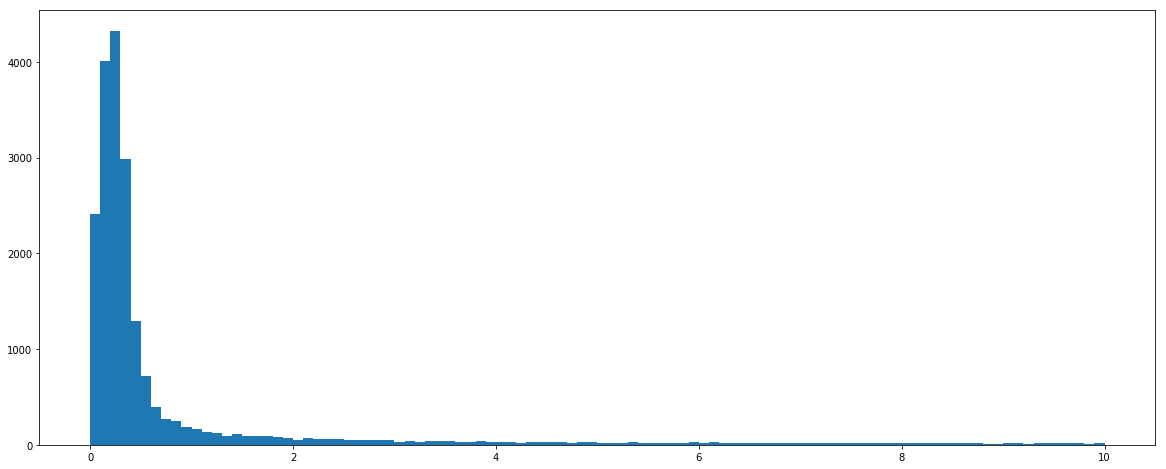

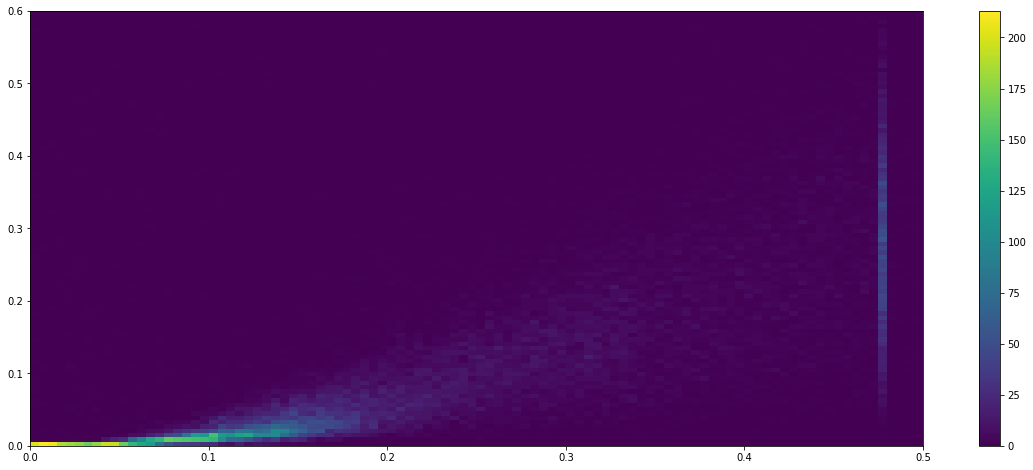

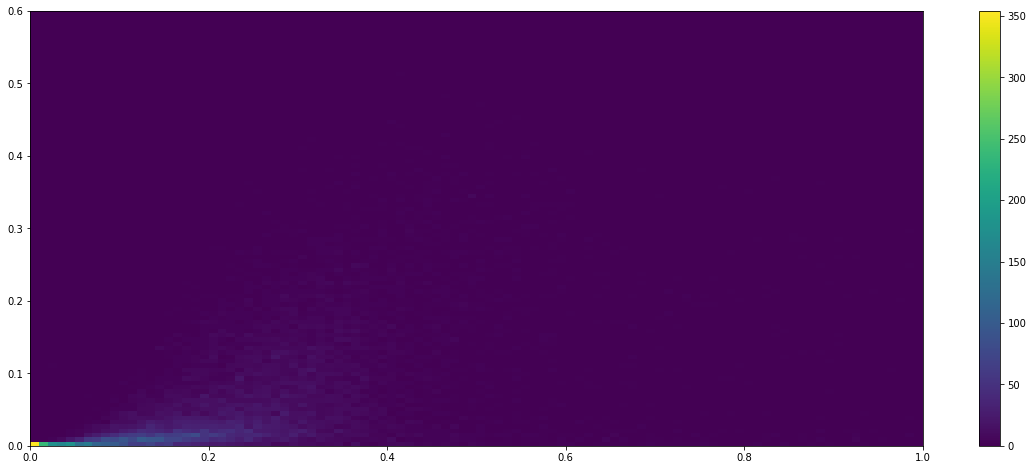

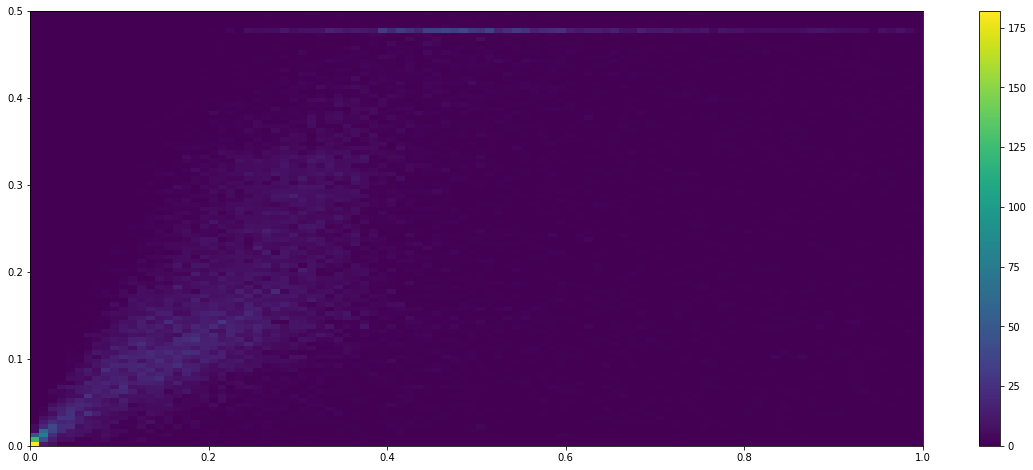

In [45]:

plt.figure(figsize=(20, 8))
plt.hist(veamoser1, bins=100, range=(0,10))

plt.figure(figsize=(20, 8))
h1=plt.hist2d(veamosen1, veamosd1, bins=100,range=[(0,0.5),(0,0.6)])
plt.colorbar(h1[3])
plt.show()

plt.show()
plt.figure(figsize=(20, 8))
h2=plt.hist2d(veamoser1,veamosd1, bins=100, range=[(0,1),(0,0.6)])
plt.colorbar(h2[3])
plt.show()

plt.figure(figsize=(20, 8))
h3=plt.hist2d(veamoser1,veamosen1, bins=100, range=[(0,1),(0,0.5)])
plt.colorbar(h3[3])
plt.show()

## Visualizamos los resultados

Visualizamos todos los sensores: 

In [ ]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Visualizamos ahora L1 a L1, teniendo en cuenta que hay de dos tipos:
L1A (con 36 columnas )

In [ ]:
n = L1A  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
n = L1B  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB],vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB],vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)

In [ ]:
print(idea)
np.sum(cara_externa_reconstruida,axis=0)

In [ ]:
veamos_energia=(np.sum(cara_externa_reconstruida, axis=1))-(np.sum(cara_externa, axis=1))
n, bins, patches = plt.hist(veamos_energia, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=200, cen=0, wid=100)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()